# **Rock Paper Scissors Image Classification**

---



# Load Library

In [6]:
# initial package
import os
import math
import random
import platform
import numpy as np
import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
# 2. Preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 3. Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
# 4. Visualize
from matplotlib.pyplot import figure,subplot,plot,legend,title,show
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.5.0


Use colab GPU
- GPU speedup over CPU: 73x

In [7]:
# checking GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load data
Upload data to drive than mount drive to colab


In [8]:
# load data from gdrive
data_dir = '/content/drive/MyDrive/Colab Notebooks/rps-cv-images/'
print(os.listdir(data_dir))

['paper', 'rock', 'scissors', 'README_rpc-cv-images.txt']


In [9]:
# Subset Data
paper_dir = os.path.join(data_dir,'paper')
scissors_dir = os.path.join(data_dir,'scissors')
rock_dir = os.path.join(data_dir,'rock')
# Show Data Quantity
print("Paper : ",len(os.listdir(paper_dir)))
print("Scissors : ",len(os.listdir(scissors_dir)))
print("Rock : ",len(os.listdir(rock_dir)))

Paper :  712
Scissors :  750
Rock :  726


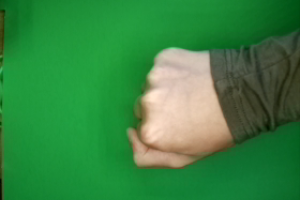

In [25]:
# Data Preview
img = load_img('/content/drive/MyDrive/Colab Notebooks/rps-cv-images/rock/2uxDLQKemRqulhIx.png')
img # rock data

# Applying Data Augmentation

In [10]:
# Define data configuration
seed=115 # for reproductible randomization
batch_size=32
img_rows,img_cols=150,150
num_classes=3

## Preprocess 
datagen = ImageDataGenerator(rescale=1/255.0,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=40,
                             zoom_range=0.25,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range=0.1,
                             fill_mode='nearest',
                             validation_split=0.4 # Split data
                             )

# Setup Generator
## Data Train
train_gen = datagen.flow_from_directory(data_dir, 
                                        target_size=(img_rows,img_cols),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        seed=seed,
                                        subset='training')

## Data Validation
validation_gen = datagen.flow_from_directory(data_dir, 
                                             target_size=(img_rows,img_cols),
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             color_mode='rgb',
                                             seed=seed, 
                                             subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


Training setup :
- Data train = 1314
- Data validation = 874

# Defining Model

In [11]:
model = Sequential([
                    # 1st Hidden layer
                    Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', 
                           input_shape=(img_rows,img_cols,num_classes)),
                    tf.keras.layers.BatchNormalization(),
                    MaxPooling2D(pool_size=(2,2)),
                    # 2nd Hidden Layer 
                    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    # 3rd Hidden Layer
                    Conv2D(filters=64, kernel_size=(3,3), padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),         
                    # 4th Hidden Layer 
                    Conv2D(filters=128, kernel_size=(3,3), padding='same',activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(rate=0.25),
                    # Outpur Layer
                    Flatten(),
                    Dropout(rate=0.5),
                    Dense(units=512, activation='relu'),
                    Dense(units=num_classes, activation='softmax')
                    ])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

# Define Callbacks

In [21]:
# Saving Point Model
filepath= "model_fin.h5" # save validation accuracy for final model
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
# Stop Running model 
early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
# Change Learning Rate while Running
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                             patience=1, 
                                             verbose=1, 
                                             factor=0.25, 
                                             min_lr=5e-06)
 
# Subset List
callbacks_list = [
                  checkpoint,
                  early_stopping,
                  learning_rate_reduction
                  ]

# Compile Model


In [13]:
# Subset Parameter
epochs=45
## From Data Augmentation
nb_train_samples=1314
nb_validation_samples=874

# Model Loss function and Optimizer
model.compile(loss = 'categorical_crossentropy', 
              optimizer= tf.keras.optimizers.Nadam(),  # Nadam is Adam with Nesterov momentum.
              metrics=['accuracy'])

# Model Fitting 
random.seed(seed)
fit = model.fit(train_gen,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs = epochs,
                    verbose = 1,
                    callbacks=callbacks_list,
                    validation_data=validation_gen,
                    validation_steps=nb_validation_samples // batch_size
                )

Epoch 1/55
41/41 [==============================] - 21s 427ms/step - loss: 1.3308 - accuracy: 0.4399 - val_loss: 1.0893 - val_accuracy: 0.3472

Epoch 00001: val_accuracy improved from -inf to 0.34722, saving model to model_fin.h5
Epoch 2/55
41/41 [==============================] - 18s 454ms/step - loss: 0.7608 - accuracy: 0.6927 - val_loss: 1.0376 - val_accuracy: 0.5486

Epoch 00002: val_accuracy improved from 0.34722 to 0.54861, saving model to model_fin.h5
Epoch 3/55
41/41 [==============================] - 18s 431ms/step - loss: 0.5026 - accuracy: 0.8112 - val_loss: 0.9562 - val_accuracy: 0.5914

Epoch 00003: val_accuracy improved from 0.54861 to 0.59144, saving model to model_fin.h5
Epoch 4/55
41/41 [==============================] - 17s 425ms/step - loss: 0.4169 - accuracy: 0.8487 - val_loss: 0.7438 - val_accuracy: 0.7465

Epoch 00004: val_accuracy improved from 0.59144 to 0.74653, saving model to model_fin.h5
Epoch 5/55
41/41 [==============================] - 18s 441ms/step - lo

# Visualize Training Result

<function matplotlib.pyplot.show>

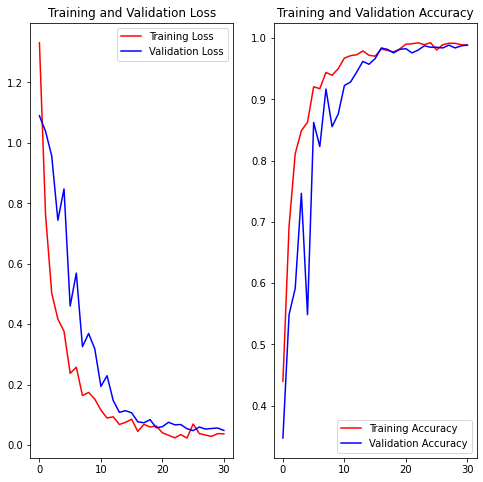

In [14]:
# Subset Result train Metric
## Y axis
accuracy = fit.history['accuracy'] # plot 1
loss = fit.history['loss'] # plot 1
val_accuracy = fit.history['val_accuracy'] # plot 2
val_loss = fit.history['val_loss'] # plot 2
## x Axis
epochs = range(len(accuracy))

# Theme
plt.style.use('seaborn')

# Training and Validation Loss
figure(figsize=(8,8))
subplot(1, 2, 1) # plot 1
plot(epochs, loss, 'r', label='Training Loss')
plot(epochs, val_loss, 'b', label='Validation Loss')
legend(loc='upper right')
plt.xlabel('epochs')
title('Training and Validation Loss')
show

# Plot Training and Validation Accuracy
subplot(1, 2, 2) # plot 2
plot(epochs, accuracy, 'r', label='Training Accuracy')
plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
legend(loc='lower right')
plt.xlabel('epochs')
title('Training and Validation Accuracy')
show

# Predict New Data

In [15]:
# Load Final Model
model_final = load_model('model_fin.h5')

In [16]:
# Check Classes Order 
labels = (train_gen.class_indices) # labels = dict((v,k) for k,v in labels.items())
labels

{'paper': 0, 'rock': 1, 'scissors': 2}

Saving kertas.jpg to kertas (1).jpg
paper


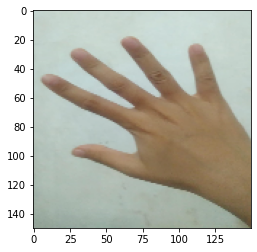

In [20]:
# Upload New Image
uploaded = files.upload()
    
for fn in uploaded.keys():
    
# Process New Image
  path = fn
  img = image.load_img(path, target_size=(img_rows,img_cols))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

# Predict Result
result = model_final.predict(images, batch_size=batch_size)

if result[0][0] == 1.0:
     print('paper')
elif result[0][1] == 1.0:
      print('rock')
elif result[0][2] == 1.0:
      print('scissors')
else:
  print('booo') # in case any error

**Data Diri**
- Nama Lengkap : Bisma Aji Manggala
- Username     : sumberpocong
- Email        : bismaam17@gmail.com